# DSCI 511: Data Acquisition and Pre-Processing <br> Term Project Phase 2: Project Implementation

# Overview

This code scrapes the ESPN website to get all NFL games played in 2022. Then, it accesses the ESPN API for each game. Then, this code creates two major outputs: (1) A directory full of JSON objects that store performance data for every player for every week. (2) A CSV file that has team-level statistics


### Part 0: Import Libraries and Initialize Lists

In [5]:
#### Import dictionaries
%load_ext autotime
from bs4 import BeautifulSoup as BS
import urllib
import requests
import re
import json
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

#Initialize lists
week_list = [x for x in range(1,19)]
game_list = list()
passing_list = list()
receiving_list = list()
rushing_list = list()

time: 282 ms (started: 2023-11-20 14:32:37 -05:00)


### Part 1: Harvest links to all the games played
I want to the game ID's of all games played in the 2022 NFL season. Use BeautifulSoup to parse the schedule websites. Example website https://www.espn.com/nfl/schedule/_/week/1/year/2022/seasontype/2

In [6]:
#### Get all games in a season
#Harvest all games from ESPN schedule
for week in week_list:
    url = 'https://www.espn.com/nfl/schedule/_/week/' + str(week) + '/year/2022/seasontype/2'
    week_html = urllib.request.urlopen(url).read()
    week_soup = BS(week_html,'html.parser')
    tables = week_soup.body.find_all('table')
    for table in tables:
        table_links = table.find_all('tr')
        for row in table_links:        
            if 'Table__TR--sm' in row.get('class'):
                game_links = row.find_all('a')
                for game_link in game_links:
                    game_id = re.findall('gameId\=[0-9]+',str(game_link))
                    if game_id:
                        game_list.append((week,re.sub('gameId\=','',game_id[0])))

time: 13.8 s (started: 2023-11-20 14:58:09 -05:00)


In [7]:
#Sanity check game_list
#Should be 32 (number of NFL teams)
len(game_list)*2/17

32.0

time: 0 ns (started: 2023-11-20 14:58:30 -05:00)


In [8]:
#Sanity check
#Should be Week 2 and with a 9 digit game ID
game_list[20]

(2, '401437645')

time: 0 ns (started: 2023-11-20 14:58:33 -05:00)


### Part 2: Make weekly directories for player data

#### 2A. Identify all the players who passed, received, or rushed

Going through every game of the 2022 season, access the play-by-play API.

For each player, create a profile of their ID, name, and a link to their photo.

In [10]:
#Use RegEx to get player ID from the player url
def extract_player_id(player_url):    
    pre_text = 'http://sports.core.api.espn.com/v2/sports/football/leagues/nfl/seasons/2022/athletes/'
    post_text = '\?lang=en\&region=us'
    id_string=re.sub(post_text,'',re.sub(pre_text,'',player_url))
    return id_string

def make_player_url(player_id):
    player_url = 'http://sports.core.api.espn.com/v2/sports/football/leagues/nfl/seasons/2022/athletes/' \
                + player_id + '?lang=en&region=us'
    return player_url

time: 0 ns (started: 2023-11-20 15:01:43 -05:00)


In [207]:
#### Get all plays in each game
print('Games pulled:',end=' ')
for game_num,game in enumerate(game_list):    
    if game_num == 0: print(game_num,end='')
    elif game_num % 25 == 0: print(', ',game_num,end='')
    else: pass
    if game_num == len(game_list) - 1: print()
    req = requests.get('https://sports.core.api.espn.com/v2/sports/football/leagues/nfl/events/' \
                 + game[1] +'/competitions/' + game[1] + '/plays?limit=1000')
    game_text = req.text
    game_json = json.loads(game_text)
    for play in game_json['items'][1:]:
        try:            
#### Get all passers, receivers, and rushers in each play
            for player in play['participants']:
                try:
                    if player['type'] =='passer':
                        passer_id = extract_player_id(player['athlete']['$ref'])
                        passing_list.append((game[0],passer_id))
                    elif player['type'] =='receiver':
                        receiver_id = extract_player_id(player['athlete']['$ref'])
                        receiving_list.append((game[0],receiver_id))
                    elif player['type'] =='rusher':
                        rusher_id = extract_player_id(player['athlete']['$ref'])
                        rushing_list.append((game[0],rusher_id))
                except KeyError:
                    pass
        except KeyError:
            pass

Games pulled: 0,  25,  50,  75,  100,  125,  150,  175,  200,  225,  250
time: 3min 13s (started: 2023-11-20 22:14:27 -05:00)


#### 2B. Count how many plays each player was involved in

In [12]:
#Perform the Count of the collected data
from collections import Counter, defaultdict
all_passers = set()
all_rushers = set()
all_receivers = set()
passers_count = defaultdict(Counter)
rushers_count = defaultdict(Counter)
receivers_count = defaultdict(Counter)

#Perform for all weeks of the season
for week in week_list:
    weekly_passers = [x[1] for x in passing_list if x[0]==week]
    weekly_rushers = [x[1] for x in rushing_list if x[0]==week]
    weekly_receivers = [x[1] for x in receiving_list if x[0]==week]

    all_passers = all_passers.union(weekly_passers)
    all_rushers = all_rushers.union(weekly_rushers)
    all_receivers = all_receivers.union(weekly_receivers)

    passers_count[week] = Counter(weekly_passers)
    rushers_count[week] = Counter(weekly_rushers)
    receivers_count[week] = Counter(weekly_receivers) 

time: 188 ms (started: 2023-11-20 15:11:16 -05:00)


#### 2C. Get bio details of each player

In [13]:
all_players = list(all_passers.union(all_rushers).union(all_receivers))
player_details = defaultdict()
for player in all_players:
    player_url = make_player_url(player)
    player_bio = json.loads(requests.get(player_url).text)
    player_details[player] = (player_url,player_bio['displayName'],player_bio['headshot']['href'])

weekly_stats_counts = {'Passing' : passers_count,
                'Rushing' : rushers_count,
                'Receiving' : receivers_count}       

time: 2min 15s (started: 2023-11-20 15:11:37 -05:00)


#### 2D. Make directory of weekly performances

In [34]:
parent_directory = "./data"
if not os.path.exists(parent_directory):
    os.makedirs(parent_directory)
    
for category in ['Passing','Rushing','Receiving']:
    # Create a directory for every category (if it doesn't exist)
    directory = "./data/"+category
    if not os.path.exists(directory):
        os.makedirs(directory)
    for week in week_list:
        player_dict = dict()
        sorted_data = sorted(weekly_stats_counts[category][week].items(), key = lambda x: x[1],reverse=True)        
        for number,player in enumerate(sorted_data):
            player_id,plays = player
            bio, name, headshot = player_details[player_id]
            player_dict[name] = { 'Rank' : number + 1, 
                                  'Plays' : plays,
                                  'Player Bio' : bio,
                                  'Headshot Link' : headshot}
        file_path = os.path.join(directory, "Week " + str(week) + ".json")
        with open(file_path, 'w') as json_file:
            json.dump(player_dict, json_file)

time: 203 ms (started: 2023-11-20 16:01:49 -05:00)


{'Rank': 1, 'Plays': 31, 'Player Bio': 'http://sports.core.api.espn.com/v2/sports/football/leagues/nfl/seasons/2022/athletes/3043078?lang=en&region=us', 'Headshot Link': 'https://a.espncdn.com/i/headshots/nfl/players/full/3043078.png'}


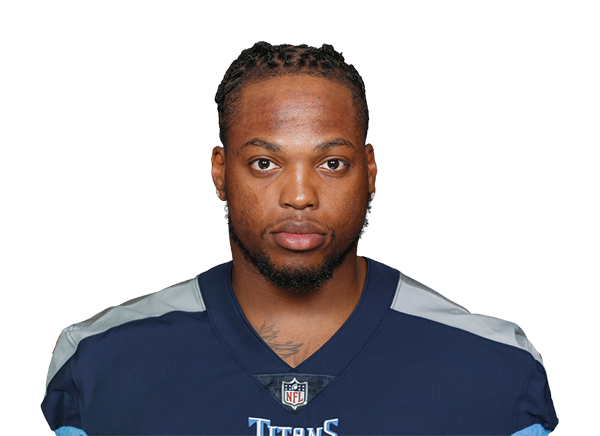

time: 313 ms (started: 2023-11-20 16:09:04 -05:00)


In [42]:
#Sanity Check
from PIL import Image

sanity_path = './data/Rushing/Week 7.json'
with open(sanity_path, 'r') as json_file:
            week7 = json.load(json_file)
derrick_henry = week7['Derrick Henry']
print(derrick_henry)
Image.open(requests.get(derrick_henry['Headshot Link'], stream = True).raw)

### Part 3: Make Full Season Dataset

#### 3A. Get information for all 32 teams

Data has Team ID, and I'd like to map to Team Name.

In [197]:
team_dict = dict()
for team_id in range(1,40):
    team_url = 'https://sports.core.api.espn.com/v2/sports/football/leagues/nfl/teams/' + str(team_id) + '?lang=en&region=us'
    team_req = requests.get(team_url)
    team_json = json.loads(team_req.text)
    try:
        team_dict[str(team_id)] = team_json['displayName']
    except KeyError:
        pass
    
#Sanity Check
team_dict['5']

'Cleveland Browns'

time: 18.5 s (started: 2023-11-20 21:11:05 -05:00)


#### 3B. Get statistics for the full season

Tracking a statistic called "Successful Play" for each team. This requires looking at every play and determining if it was successful, using this criteria:
- If first down: Need to gain half the needed yardage
- If second down: Need to gain 70% of the needed yardage
- If third or fourth down: Need to gain all the needed yardage

Use Pandas to manipulate and store the data. Also, I want to keep separate running and passing play performance.

In [186]:
full_season_data = pd.DataFrame()

import warnings 
warnings.filterwarnings('ignore')

print('Games pulled:',end=' ')

for game_num,game in enumerate(game_list): 
    team_list, team_week_list, successful, play_type_list = [],[],[],[]
    if game_num == 0: print(game_num,end='')
    elif game_num % 25 == 0: print(', ',game_num,end='')
    else: pass
    if game_num == len(game_list) - 1: print()    
    req = requests.get('https://sports.core.api.espn.com/v2/sports/football/leagues/nfl/events/' \
                 + game[1] +'/competitions/' + game[1] + '/plays?limit=1000')
    game_text = req.text
    game_json = json.loads(game_text)
    for play in game_json['items']:
        #Filter out non-offensive plays (e.g. Kick-offs, Timeouts)
        play_type = play['type']['text']
        if play_type in ['Rush', 'Rushing Touchdown','Pass Incompletion','Pass Reception','Sack','Passing Touchdown']:
            team = re.search(r'teams/(\d+)',play['team']['$ref']).group(0)[6:]
            start_down = play['start']['down']
            start_distance = play['start']['distance']
            yards_gained = play['statYardage']
            #Define successful play
            if 'Touchdown' in play_type: successful.append(1)
            elif start_down == 1:
                if yards_gained >= start_distance * .5: successful.append(1)
                else: successful.append(0)
            elif start_down == 2:
                if yards_gained >= start_distance * .7: successful.append(1)
                else: successful.append(0)
            elif start_down >2:
                if yards_gained >= start_distance: successful.append(1)
                else: successful.append(0)
            else:
                print('Invalid down')
            if play_type in ['Rush', 'Rushing Touchdown']:
                play_type_list.append('Rushing Play')
            else:
                play_type_list.append('Passing Play')
            team_list.append(team)
            
        else:
            pass
    full_game_df = pd.DataFrame({'Team ID' : team_list, 
                                 'Successful Play' : successful, 
                                 'Play Type' : play_type_list})
    full_game_pivot = full_game_df.pivot_table('Successful Play', 'Team ID','Play Type',aggfunc='mean')
    full_game_pivot['Week'] = game[0]
    full_season_data = full_season_data.append(full_game_pivot)

full_season_data.columns.name =  'Index'
full_season_data = full_season_data.reset_index()
full_season_data['Team Name'] = full_season_data['Team ID'].map(team_dict)

Games pulled: 0,  25,  50,  75,  100,  125,  150,  175,  200,  225,  250
time: 3min 8s (started: 2023-11-20 20:04:09 -05:00)


In [205]:
#Sanity Check
find_top_teams = full_season_data.groupby('Team Name').mean()[['Rushing Play','Passing Play']]
print('Top Passing Teams')
print(find_top_teams.sort_values(by='Passing Play',ascending=False).index.to_list()[:5])
print()
print('Top Rushing Teams')
print(find_top_teams.sort_values(by='Rushing Play',ascending=False).index.to_list()[:5])
print()

Top Passing Teams
['Kansas City Chiefs', 'Buffalo Bills', 'Detroit Lions', 'San Francisco 49ers', 'Dallas Cowboys']

Top Rushing Teams
['Philadelphia Eagles', 'Buffalo Bills', 'Baltimore Ravens', 'Atlanta Falcons', 'Las Vegas Raiders']

time: 16 ms (started: 2023-11-20 21:27:37 -05:00)


The above teams all had offenses that were considered very good in 2022

#### 3C. Export the data to CSV

In [199]:
full_season_data.to_csv('./data/successful_play_data.csv')

time: 16 ms (started: 2023-11-20 21:17:39 -05:00)


#### Appendix

This includes a sample visual that may be useful in understanding the data sources created.

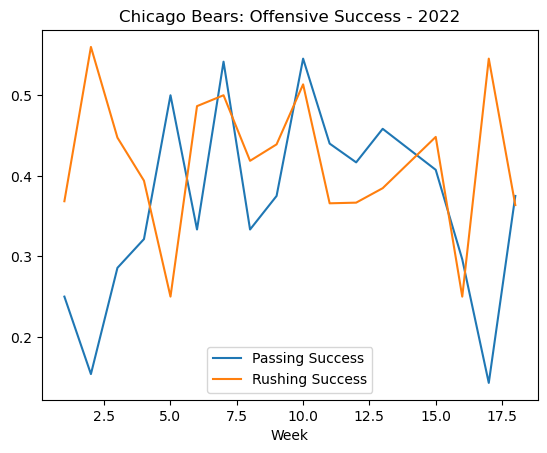

time: 219 ms (started: 2023-11-20 20:12:52 -05:00)


In [190]:
import matplotlib.pyplot as plt

def show_success_graphs(data,team):
    season = data[data['Team Name']==team]
    plt.plot(season['Week'],season['Passing Play'])
    plt.plot(season['Week'],season['Rushing Play'])
    plt.legend(['Passing Success','Rushing Success'])
    plt.title(team + ': Offensive Success - 2022')
    plt.xlabel('Week')
    plt.show()

show_success_graphs(full_season_data,'Chicago Bears')    

In [ ]:
all_teams_performance = full_season_data.groupby('Team Name').mean()[['Rushing Play','Passing Play']].reset_index()

plt.scatterplot(modeling_steps, annoyance_scores, 'o')

# Adding titles and labels
plt.title('Annoyance Score after Each Modeling Step')
plt.ylabel('Annoyance (Test Data)')
plt.xlabel('Modeling Step')

# Adjusting the fontsize of the x-ticks
plt.xticks(fontsize=10)

# Annotating every tenth data point
for i, (x, y) in enumerate(zip(modeling_steps, annoyance_scores)):
    if i % 10 == 0:  # Change 10 to another number if you want a different interval
        plt.annotate(f'({x:.1f}, {y:.1f})',  # Format to one decimal place
                     (x, y), 
                     textcoords="offset points",  # Positioning
                     xytext=(0,10),  # Distance from the point
                     ha='center')    # Horizontal alignment

# Showing the plot
plt.show()

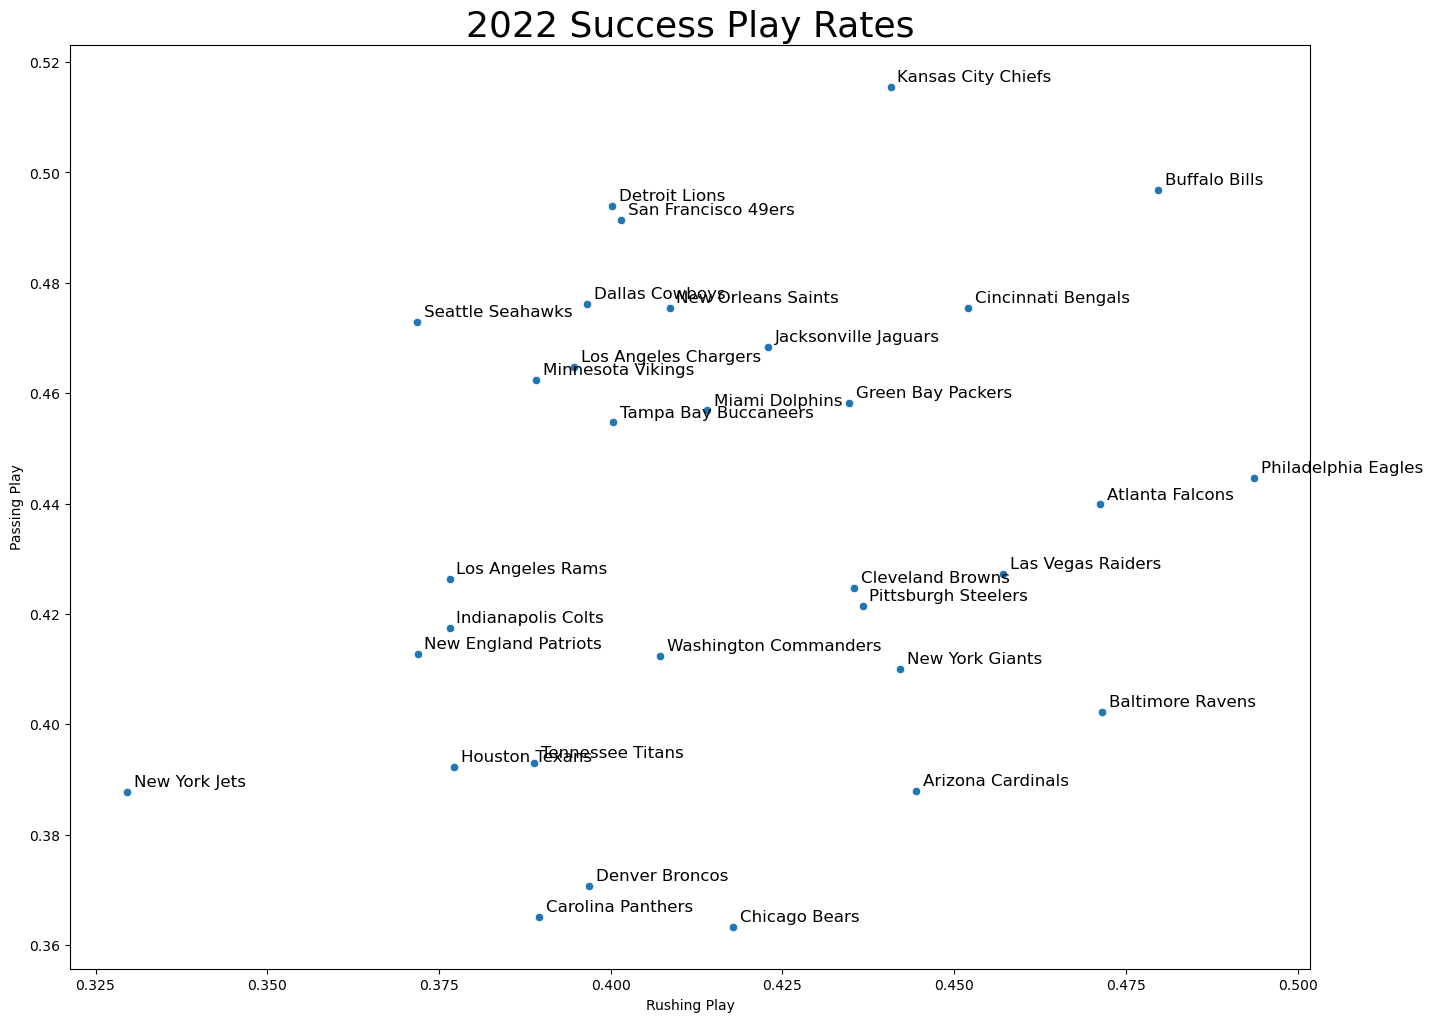

time: 484 ms (started: 2023-11-20 22:29:39 -05:00)


In [225]:
import seaborn as sns
all_teams_performance = full_season_data.groupby('Team Name').mean()[['Rushing Play','Passing Play']].reset_index()
plt.figure(figsize=(16,12))
sns.scatterplot(data=all_teams_performance,x='Rushing Play',y='Passing Play')
plt.title('2022 Success Play Rates',fontsize=26)
for i in range(len(all_teams_performance)):
    plt.text(x=all_teams_performance['Rushing Play'][i]+.001, 
             y = all_teams_performance['Passing Play'][i]+.001,
             s=all_teams_performance['Team Name'][i],
             fontdict=dict(size=12))
plt.show()